In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cross-Attention Block

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os

This module implements cross-modal multihead attention

Query comes from one source/modality

Key & Value come from another source/modality
(e.g., text attends to audio, video attends to text, etc.)

In [ ]:
class CrossAttention(nn.Module):
    #Attention is split into 8 parallel heads
    def __init__(self, dim=768, num_heads=8, dropout=0.3):#Each head learns different alignment patterns.
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True #[Batch, Sequence, Features]
        )
        self.norm = nn.LayerNorm(dim) #Normalizes across features, Prevents one modality from dominating

    def forward(self, query, key_value):
        """
        This function lets one token (query) attend to a sequence of tokens (key/value) and returns a context-aware enriched query.

        query: [B, 1, D]
        B → batch size
        1 → exactly one token
        D → embedding dimension (e.g., 768)

        key_value: [B, N, D]
        N → number of tokens in another modality
        Audio frames
        Video patches
        Text tokens

        """
        #cross-attention computation
        attn_out, _ = self.attn(query, key_value, key_value) #attn_out=αV , _ contains attention maps
       # Residual connection , LayerNorm —> stabilizing the fusion
        return self.norm(attn_out + query)


Multimodal Cross-Attention Emotion Model

Cross-attention layers → help the model understand audio, text, and video together
“Which parts of audio/text/video matter?”

Classifier head → makes the final call:
“Which emotion is this?”

--------------------------------------------------------------------------------------------------------------

Attention answers:“Which parts of audio/text/video matter?”

classification answers:“So what emotion does that mean?”



In [ ]:
import torch.nn as nn
import torch

class MultimodalEmotionModel(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, num_classes=8, dropout=0.3):
        super().__init__()
        #Learned NULL embeddings
        """ These are learnable placeholders.
            If one modality is missing, the model uses a learned null vector instead of undefined prediction/behaviour.

            Importance:
            1.Handles missing audio / text / video
            2.NULL vectors are trained, not fixed zeros
            3.Model learns how “absence” should influence emotion

            Shape: [768]
        """
        self.null_text   = nn.Parameter(torch.zeros(embed_dim))
        self.null_vision = nn.Parameter(torch.zeros(embed_dim))
        self.null_audio  = nn.Parameter(torch.zeros(embed_dim))


        #Cross-attention layers
        #This creates bidirectional multimodal understanding.
        self.audio_to_tv = CrossAttention(embed_dim, num_heads)  #Audio attends to Text + Vision
        self.text_to_av  = CrossAttention(embed_dim, num_heads)  #Text attends to Audio + Vision
        self.vision_to_at = CrossAttention(embed_dim, num_heads) #Vision attends to Audio + Text

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 3, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, audio, text, vision, masks):

        # -------- MASKS --------
        text_mask   = masks[:, 0].unsqueeze(1)   # [B,1]
        vision_mask = masks[:, 1].unsqueeze(1)   # [B,1]
        audio_mask = masks[:, 2].unsqueeze(1)   # [B,1]

        # Replace missing modalities with learned NULL embeddings
        text = text_mask * text + (1 - text_mask) * self.null_text.unsqueeze(0)
        vision = vision_mask * vision + (1 - vision_mask) * self.null_vision.unsqueeze(0)
        audio = audio_mask * audio + (1 - audio_mask) * self.null_audio.unsqueeze(0)

        # -------- Attention Preparation --------
         #unsqueeze(1) turns a vector into a one-step sequence so attention can read it. ( attention only works on sequences)
        # [B,D](Batch, Features)->[B,T,D]([Batch, Sequence, Features])
        a = audio.unsqueeze(1)   # [B,1,D]
        t = text.unsqueeze(1)
        v = vision.unsqueeze(1)

        # Context pairs
        """
            Concatenation creates a context window of other modalities.
            a : [B, 1, 768]  → audio
            t : [B, 1, 768]  → text
            v : [B, 1, 768]  → vision

            Audio  → looks at [Text, Vision]
            Text   → looks at [Audio, Vision]
            Vision → looks at [Audio, Text]
        """

        tv = torch.cat([t, v], dim=1) #When AUDIO is thinking, let it look at both TEXT and VISION together.
        av = torch.cat([a, v], dim=1) #When TEXT is thinking, let it look at AUDIO and VISION together.
        at = torch.cat([a, t], dim=1) #When VISION is thinking, let it look at AUDIO and TEXT together.

        # Cross-attention fusion
        """
        Audio listens to text and vision, learns what matters, and becomes smarter

        a is the query (audio)
        tv is key/value (text + vision)
        Cross-attention happens inside

        a_fused = audio embedding enriched by text + vision

        """
        a_fused = self.audio_to_tv(a, tv).squeeze(1)
        t_fused = self.text_to_av(t, av).squeeze(1)
        v_fused = self.vision_to_at(v, at).squeeze(1)

        # Final fused representation
        fused = torch.cat([a_fused, t_fused, v_fused], dim=1)

        return self.classifier(fused)


Dataset Loader

In [ ]:
class MultiModelDataset(torch.utils.data.Dataset):
    def __init__(self, audio_dir, text_dir, vision_dir, labels, embed_dim=768):
        self.ids = list(labels.keys())
        self.audio_dir = audio_dir
        self.text_dir = text_dir
        self.vision_dir = vision_dir
        self.labels = labels
        self.embed_dim = embed_dim

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        vid = self.ids[idx]

        audio_path = f"{self.audio_dir}/{vid}.pt"
        text_path = f"{self.text_dir}/{vid}.pt"
        vision_path = f"{self.vision_dir}/{vid}.pt"

        if os.path.exists(audio_path):
            def_zero_embed = torch.load(audio_path).float()
        elif os.path.exists(text_path):
            def_zero_embed = torch.load(text_path).float()
        elif os.path.exists(vision_path):
            def_zero_embed  = torch.load(vision_path).float()


        # -------- AUDIO-------
        #audio_path = f"{self.audio_dir}/{vid}.pt"
        if os.path.exists(audio_path):
            audio = torch.load(audio_path).float()
            if audio.dim() > 1:
                audio = audio.squeeze(0)
            audio_mask = 1.0
        else:
            audio = torch.zeros_like(def_zero_embed)
            audio_mask = 0.0

        # -------- TEXT--------
        #text_path = f"{self.text_dir}/{vid}.pt"
        if os.path.exists(text_path):
            text = torch.load(text_path).float()
            if text.dim() > 1:
                text = text.squeeze(0)
            text_mask = 1.0
        else:
            text = torch.zeros_like(def_zero_embed)
            text_mask = 0.0

        # -------- VISION--------
        #vision_path = f"{self.vision_dir}/{vid}.pt"
        if os.path.exists(vision_path):
            vision = torch.load(vision_path).float()
            if vision.dim() > 1:
                vision = vision.squeeze(0)
            vision_mask = 1.0
        else:
            vision = torch.zeros_like(def_zero_embed)
            vision_mask = 0.0

        # -------- LABEL --------
        label = torch.tensor(self.labels[vid], dtype=torch.long)

        #Masks: [Text present?, Vision present? , Audio ?]
        masks = torch.tensor([text_mask, vision_mask, audio_mask], dtype=torch.float)

        return audio, text, vision, masks, label

In [ ]:
import torch
from torch.utils.data import Dataset

class CachedDataset(Dataset):
    def __init__(self, base_dataset):
        print("Caching dataset into RAM...")

        self.cached = []
        for i in range(len(base_dataset)):
            self.cached.append(base_dataset[i])

        print("✅ Done caching. Total samples:", len(self.cached))

    def __len__(self):
        return len(self.cached)

    def __getitem__(self, idx):
        return self.cached[idx]


Training Setup

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLASSES = 8
BATCH_SIZE = 64
EPOCHS = 30
LR = 3e-4


Load Dataset

In [ ]:
import json

file_path = "/content/drive/MyDrive/Dissertion/Data/labels/data_labels.json"




with open(file_path, "r") as f:
    data_labels = json.load(f)

#test code
#data_labels = dict(list(data_labels.items())[:50])


"""
data_labels = {
    # Example:
    # "01-02-01-01-01-01-01": 0,
    # "01-02-02-02-01-01-02": 4,
}
"""

print(type(data_labels))   # dict
print(len(data_labels))    # number of entries
print(next(iter(data_labels.items())))
#print(data_labels)

<class 'dict'>
10765
('01-02-03-01-02-01-07', 2)


In [ ]:
!cp -r "/content/drive/MyDrive/Dissertion/Data/Features" /content/features_local


In [ ]:
!du -sh /content/features_local



230M	/content/features_local


In [ ]:
#AUDIO_FEATURE_PATH = "/content/drive/MyDrive/Dissertion/Data/Features/audio"
AUDIO_FEATURE_PATH = "/content/features_local/audio"
TEXT_FEATURE_PATH = "/content/features_local/text"
VISION_FEATURE_PATH = "/content/features_local/vision"

dataset = MultiModelDataset(
    audio_dir=AUDIO_FEATURE_PATH,
    text_dir=TEXT_FEATURE_PATH,
    vision_dir=VISION_FEATURE_PATH,
    labels=data_labels
)

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                    drop_last=True , num_workers=2,pin_memory=True)

#test loader

In [ ]:
batch = next(iter(loader))

audio, text, vision, _,labels = batch

print("Audio :", audio.shape)
print("Text  :", text.shape)
print("Vision:", vision.shape)
print("Labels:", labels.shape)


Audio : torch.Size([64, 768])
Text  : torch.Size([64, 768])
Vision: torch.Size([64, 768])
Labels: torch.Size([64])


#missing modalities

In [ ]:
missing_text = 0
missing_vision = 0
missing_audio = 0

for vid in dataset.ids:
    if not os.path.exists(f"{TEXT_FEATURE_PATH}/{vid}.pt"):
        missing_text += 1

    if not os.path.exists(f"{VISION_FEATURE_PATH}/{vid}.pt"):
        missing_vision += 1

    if not os.path.exists(f"{AUDIO_FEATURE_PATH}/{vid}.pt"):
        missing_audio += 1

print("Missing Text Features :", missing_text)
print("Missing Vision Features:", missing_vision)
print("Missing Audio Features:", missing_audio)


Missing Text Features : 637
Missing Vision Features: 2408
Missing Audio Features: 0


#stratified data split

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from collections import Counter

# -------------------------
# Step 0: Prepare IDs + Labels
# -------------------------
all_ids = list(data_labels.keys())
all_labels = [data_labels[x] for x in all_ids]

# -------------------------
# Step 1: Train (70%) vs Temp (30%)
# -------------------------
train_ids, temp_ids = train_test_split(
    all_ids,
    test_size=0.30,
    random_state=42,
    stratify=all_labels
)

# Labels for temp split
temp_labels = [data_labels[x] for x in temp_ids]

# -------------------------
# Step 2: Temp → Val (15%) + Test (15%)
# -------------------------
val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=0.50,
    random_state=42,
    stratify=temp_labels
)

# -------------------------
# Step 3: Map IDs → Dataset Indices
# -------------------------
id_to_index = {vid: i for i, vid in enumerate(dataset.ids)}

train_indices = [id_to_index[x] for x in train_ids]
val_indices   = [id_to_index[x] for x in val_ids]
test_indices  = [id_to_index[x] for x in test_ids]

# -------------------------
# Step 4: Create Subsets
# -------------------------
train_dataset = Subset(dataset, train_indices)
val_dataset   = Subset(dataset, val_indices)
test_dataset  = Subset(dataset, test_indices)


# -------------------------
# Step 5: Verify Distributions
# -------------------------
print("Train distribution:", Counter([data_labels[dataset.ids[i]] for i in train_indices]))
print("Val distribution  :", Counter([data_labels[dataset.ids[i]] for i in val_indices]))
print("Test distribution :", Counter([data_labels[dataset.ids[i]] for i in test_indices]))

print("Train size:", len(train_dataset))
print("Val size  :", len(val_dataset))
print("Test size :", len(test_dataset))


Train distribution: Counter({0: 2777, 2: 1252, 1: 1042, 4: 914, 3: 673, 5: 478, 6: 265, 7: 134})
Val distribution  : Counter({0: 595, 2: 268, 1: 223, 4: 195, 3: 145, 5: 103, 6: 57, 7: 29})
Test distribution : Counter({0: 596, 2: 268, 1: 223, 4: 196, 3: 144, 5: 102, 6: 57, 7: 29})
Train size: 7535
Val size  : 1615
Test size : 1615


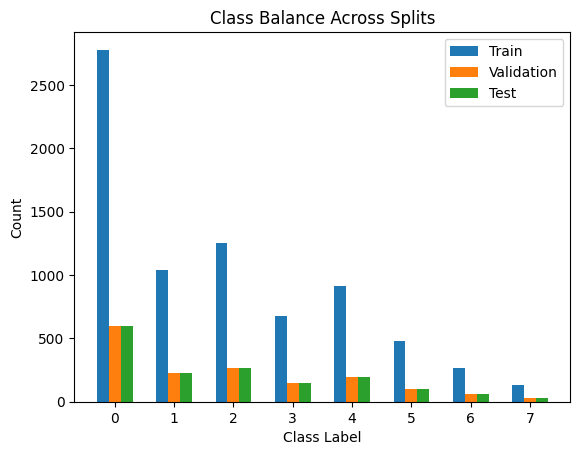

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Example label extraction from subsets
def get_labels(subset, dataset, data_labels):
    return [data_labels[dataset.ids[i]] for i in subset.indices]

train_labels = get_labels(train_dataset, dataset, data_labels)
val_labels   = get_labels(val_dataset, dataset, data_labels)
test_labels  = get_labels(test_dataset, dataset, data_labels)

train_count = Counter(train_labels)
val_count   = Counter(val_labels)
test_count  = Counter(test_labels)

classes = sorted(set(train_labels + val_labels + test_labels))

train_values = [train_count[c] for c in classes]
val_values   = [val_count[c] for c in classes]
test_values  = [test_count[c] for c in classes]

plt.figure()
x = range(len(classes))

plt.bar([i - 0.2 for i in x], train_values, width=0.2, label="Train")
plt.bar(x, val_values, width=0.2, label="Validation")
plt.bar([i + 0.2 for i in x], test_values, width=0.2, label="Test")

plt.xticks(x, classes)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Balance Across Splits")
plt.legend()
plt.show()



In [ ]:
from torch.utils.data import WeightedRandomSampler
import numpy as np

# -------------------------
# Step A: Get train labels from indices
# -------------------------
train_labels = [data_labels[dataset.ids[i]] for i in train_indices]

# Count samples per class
class_counts = np.bincount(train_labels)

print("Class counts (train):", class_counts)

# -------------------------
# Step B: Compute weight per class
# -------------------------
class_weights = 1.0 / class_counts

print("Class weights:", class_weights)

# -------------------------
# Step C: Assign weight per training sample
# -------------------------
sample_weights = [class_weights[label] for label in train_labels]

# -------------------------
# Step D: Create sampler
# -------------------------
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


Class counts (train): [2777 1042 1252  673  914  478  265  134]
Class weights: [0.0003601  0.00095969 0.00079872 0.00148588 0.00109409 0.00209205
 0.00377358 0.00746269]


In [ ]:

cached_train_dataset = CachedDataset(train_dataset)
cached_val_dataset = CachedDataset(val_dataset)
cached_test_dataset = CachedDataset(test_dataset)

# -------------------------
# Step 5: DataLoaders
# -------------------------
train_loader = DataLoader(
    cached_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    cached_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

test_loader = DataLoader(
    cached_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

Caching dataset into RAM...
✅ Done caching. Total samples: 7535
Caching dataset into RAM...
✅ Done caching. Total samples: 1615
Caching dataset into RAM...
✅ Done caching. Total samples: 1615


#Initialize Model

In [ ]:
model = MultimodalEmotionModel(num_classes=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-5,
    weight_decay=1e-3
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)



Training Loop

In [ ]:
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Dissertion/model"

    #create mmodel directory if does not exist
if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
MODEL_NAME = "multimodal_emotion_model.pth"

model_save_path = os.path.join(MODEL_PATH, MODEL_NAME)

def save_best_model():
   torch.save(model.state_dict(), model_save_path)

In [ ]:
def train(model, loader, criterion, optimizer, device, scaler):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for audio, text, vision, masks, label in loader:

        # Move to GPU
        audio  = audio.to(device, non_blocking=True)
        text   = text.to(device, non_blocking=True)
        vision = vision.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True)
        label  = label.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Mixed Precision Forward
        with torch.amp.autocast("cuda"):
            logits = model(audio, text, vision, masks)
            loss   = criterion(logits, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        preds = logits.argmax(dim=1)
        correct += (preds == label).sum().item()
        total += label.size(0)

    return total_loss / len(loader), correct / total


In [ ]:
@torch.inference_mode()
def evaluate(model, loader, criterion, device):

    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for audio, text, vision, masks, label in loader:

        audio  = audio.to(device, non_blocking=True)
        text   = text.to(device, non_blocking=True)
        vision = vision.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True)
        label  = label.to(device, non_blocking=True)

        with torch.amp.autocast("cuda"):
            logits = model(audio, text, vision, masks)
            loss   = criterion(logits, label)

        total_loss += loss.item()

        preds = logits.argmax(dim=1)
        correct += (preds == label).sum().item()
        total += label.size(0)


    return total_loss / len(loader), correct / total


In [ ]:
EPOCHS = 30

In [ ]:
best_val_loss = float("inf")
scaler = torch.amp.GradScaler("cuda")


for epoch in range(EPOCHS):
    # ---------- TRAIN ----------
    train_loss, train_acc = train(
        model=model,
        loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        scaler=scaler
    )

    # ---------- VALIDATION ----------
    val_loss, val_acc = evaluate(
        model=model,
        loader=val_loader,
        criterion=criterion,
        device=DEVICE
    )

    train_losses.append(train_loss)
    train_accuracies.append(train_acc * 100)  # %
    val_losses.append(val_loss)
    val_accuracies.append(val_acc * 100)

    # ---------- LOG ----------
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%"
    )

    scheduler.step(val_acc)
    print("LR now:", optimizer.param_groups[0]["lr"])


    # ---------- SAVE BEST MODEL ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_best_model()

print("Training completed!!")

Epoch [1/30] | Train Loss: 1.7472, Train Acc: 39.70% | Val Loss: 1.6980, Val Acc: 42.85%
LR now: 5e-05
Epoch [2/30] | Train Loss: 1.6640, Train Acc: 43.27% | Val Loss: 1.6507, Val Acc: 45.51%
LR now: 5e-05
Epoch [3/30] | Train Loss: 1.6141, Train Acc: 45.99% | Val Loss: 1.6016, Val Acc: 46.75%
LR now: 5e-05
Epoch [4/30] | Train Loss: 1.5593, Train Acc: 48.64% | Val Loss: 1.5613, Val Acc: 49.60%
LR now: 5e-05
Epoch [5/30] | Train Loss: 1.5138, Train Acc: 50.83% | Val Loss: 1.5294, Val Acc: 50.90%
LR now: 5e-05
Epoch [6/30] | Train Loss: 1.4751, Train Acc: 52.70% | Val Loss: 1.5043, Val Acc: 52.51%
LR now: 5e-05
Epoch [7/30] | Train Loss: 1.4370, Train Acc: 54.67% | Val Loss: 1.4846, Val Acc: 52.57%
LR now: 5e-05
Epoch [8/30] | Train Loss: 1.4051, Train Acc: 55.93% | Val Loss: 1.4745, Val Acc: 53.00%
LR now: 5e-05
Epoch [9/30] | Train Loss: 1.3880, Train Acc: 56.76% | Val Loss: 1.4626, Val Acc: 54.49%
LR now: 5e-05
Epoch [10/30] | Train Loss: 1.3618, Train Acc: 58.36% | Val Loss: 1.4639,

In [ ]:
# Load best model selected by validation
model.load_state_dict(torch.load(model_save_path))
model.to(DEVICE)
scaler = torch.cuda.amp.GradScaler()
print("Test model...")
# ---------- TEST ----------
test_loss, test_acc = evaluate(
    model=model,
    loader=test_loader,
    criterion=criterion,
    device=DEVICE
)

print("\n===== FINAL GENERALIZATION RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")


Test model...

===== FINAL GENERALIZATION RESULTS =====
Test Loss: 1.4306
Test Accuracy: 56.16%


/tmp/ipython-input-4215588801.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def plot_epochwise_metrics(
    train_losses,
    val_losses,
    train_accuracies,
    val_accuracies,
    num_classes
):
    epochs = range(1, len(train_losses) + 1)

    random_loss = np.log(num_classes)

    plt.figure(figsize=(12, 5))

    # -------- Loss Plot --------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', label='Train Loss')
    plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
    plt.axhline(
        y=random_loss,
        color='gray',
        linestyle='--',
        label=f'Random Guess Loss (log({num_classes}))'
    )

    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.grid(True)

    # -------- Accuracy Plot --------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, marker='o', label='Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Epochs')
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


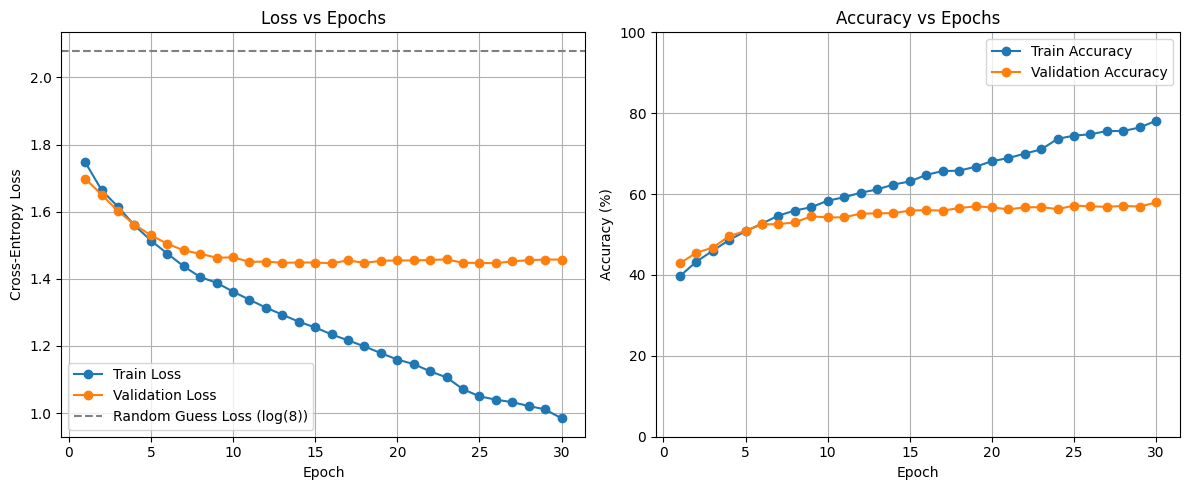

In [ ]:
NUM_CLASSES = 8

plot_epochwise_metrics(
    train_losses,
    val_losses,
    train_accuracies,
    val_accuracies,
    num_classes=NUM_CLASSES
)


Metrics

In [ ]:
import torch
import numpy as np

@torch.inference_mode()
def evaluate_with_preds(model, loader, criterion, device):

    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for audio, text, vision, masks, label in loader:

        # Move to GPU
        audio  = audio.to(device, non_blocking=True)
        text   = text.to(device, non_blocking=True)
        vision = vision.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True)
        label  = label.to(device, non_blocking=True)

        # Forward (AMP optional)
        with torch.amp.autocast("cuda"):
            logits = model(audio, text, vision, masks)
            loss   = criterion(logits, label)

        total_loss += loss.item()

        preds = logits.argmax(dim=1)

        correct += (preds == label).sum().item()
        total += label.size(0)

        # Store for metrics
        all_preds.append(preds.cpu().numpy())
        all_labels.append(label.cpu().numpy())

    # Convert list → array
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = correct / total
    avg_loss = total_loss / len(loader)

    return avg_loss, acc, all_labels, all_preds


Macro-F1, Per-Class Recall, Classification Report

Macro F1 (most important)

Recall for each emotion class

Full classification report

In [ ]:
from sklearn.metrics import f1_score, recall_score, classification_report

def compute_metrics(y_true, y_pred, class_names=None):

    # Macro-F1 (treat all classes equally)
    macro_f1 = f1_score(y_true, y_pred, average="macro")

    #  Per-class recall
    per_class_recall = recall_score(y_true, y_pred, average=None)

    print("\n==============================")
    print("Metrics Report")
    print("==============================")

    print(f"Macro-F1 Score: {macro_f1:.4f}\n")

    # Print per-class recall
    print("Per-Class Recall:")
    for i, r in enumerate(per_class_recall):
        name = class_names[i] if class_names else f"Class {i}"
        print(f"  {name:15s}: {r:.4f}")

    # Full classification report
    print("\nFull Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return macro_f1, per_class_recall


Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax)
    plt.title("Confusion Matrix")
    plt.show()



Validation Accuracy: 0.5603715170278638

Metrics Report
Macro-F1 Score: 0.4847

Per-Class Recall:
  neutral        : 0.8437
  calm           : 0.3946
  happy          : 0.3470
  sad            : 0.3655
  angry          : 0.4513
  fearful        : 0.4854
  disgust        : 0.1930
  surprised      : 0.6897

Full Classification Report:

              precision    recall  f1-score   support

     neutral       0.56      0.84      0.68       595
        calm       0.61      0.39      0.48       223
       happy       0.53      0.35      0.42       268
         sad       0.51      0.37      0.43       145
       angry       0.60      0.45      0.51       195
     fearful       0.54      0.49      0.51       103
     disgust       0.58      0.19      0.29        57
   surprised       0.48      0.69      0.56        29

    accuracy                           0.56      1615
   macro avg       0.55      0.47      0.48      1615
weighted avg       0.56      0.56      0.54      1615



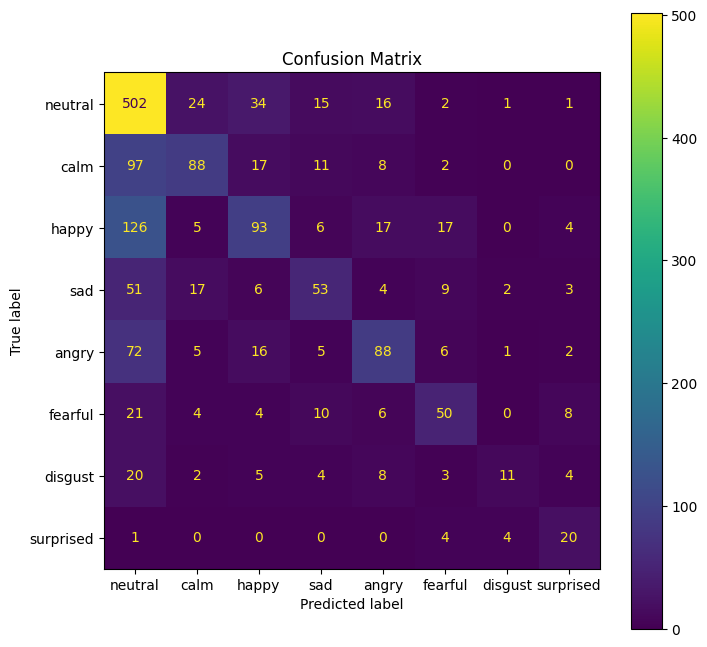

In [ ]:
emotion_classes = [
    "neutral", "calm", "happy", "sad",
    "angry", "fearful", "disgust", "surprised"
]

# Evaluate on validation set
val_loss, val_acc, y_true, y_pred = evaluate_with_preds(
    model, val_loader, criterion, DEVICE
)

print("\nValidation Accuracy:", val_acc)

# Macro-F1 + Recall
macro_f1, per_class_recall = compute_metrics(
    y_true, y_pred, class_names=emotion_classes
)

# Confusion Matrix
plot_confusion_matrix(
    y_true, y_pred, class_names=emotion_classes
)
